In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# %%

In [2]:
# Load the dataset
data = pd.read_csv('C:/B.Tech/B.Tech Projects/3rd year/PAD/Sleep_Analysis.csv')

In [3]:
print("Dataset Info:")
print(data.info())
print("\nFirst 5 rows:")
print(data.head())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Age               46 non-null     int64  
 1   Gender            46 non-null     object 
 2   meals/day         46 non-null     object 
 3   physical illness  46 non-null     object 
 4   screen time       46 non-null     object 
 5   bluelight filter  46 non-null     object 
 6   sleep direction   46 non-null     object 
 7   exercise          46 non-null     object 
 8   smoke/drink       46 non-null     object 
 9   beverage          46 non-null     object 
 10  sleep time        46 non-null     float64
dtypes: float64(1), int64(1), object(9)
memory usage: 4.1+ KB
None

First 5 rows:
   Age  Gender meals/day physical illness  screen time bluelight filter  \
0   22    Male       two               no         2hrs              yes   
1   22  Female     three               n

In [4]:
# Check for missing values
print("\nMissing values:")
print(data.isnull().sum())


Missing values:
Age                 0
Gender              0
meals/day           0
physical illness    0
screen time         0
bluelight filter    0
sleep direction     0
exercise            0
smoke/drink         0
beverage            0
sleep time          0
dtype: int64


In [5]:
# Handle 'Prefer not to say' in Gender column
data['Gender'] = data['Gender'].replace('Prefer not to say', 'Other')

# Convert 'sleep time' to numeric (in case it's not)
data['sleep time'] = pd.to_numeric(data['sleep time'], errors='coerce')

In [6]:
def extract_screen_time(x):
    if 'hrs' in x:
        if '-' in x:
            # For ranges like '3-4 hrs', take average
            low, high = x.split('-')
            low = float(low.split()[0])
            high = float(high.split()[0])
            return (low + high) / 2
        else:
            # For single values like '2hrs'
            return float(x.split('hrs')[0])
    elif 'more than 5' in x:
        return 6  # Assuming more than 5 means 6 hours
    elif '0-1' in x:
        return 0.5
    else:
        return np.nan

In [7]:
data['screen_time_numeric'] = data['screen time'].apply(extract_screen_time)

# Convert 'meals/day' to numerical
meal_mapping = {
    'one': 1,
    'two': 2,
    'three': 3,
    'four': 4,
    'five': 5,
    'more than 5': 6
}
data['meals_numeric'] = data['meals/day'].map(meal_mapping)

# Convert binary columns to 0/1
data['physical illness'] = data['physical illness'].map({'yes': 1, 'no': 0})
data['bluelight filter'] = data['bluelight filter'].map({'yes': 1, 'no': 0})
data['smoke/drink'] = data['smoke/drink'].map({'yes': 1, 'no': 0})


In [8]:
exercise_mapping = {
    'no': 0,
    'sometimes': 1,
    'yes': 2
}
data['exercise_numeric'] = data['exercise'].map(exercise_mapping)

# %%
# Exploratory Data Analysis

# Basic statistics
print("\nDescriptive Statistics:")
print(data.describe())


Descriptive Statistics:
             Age  physical illness  bluelight filter  smoke/drink  sleep time  \
count  46.000000         46.000000         46.000000    46.000000   46.000000   
mean   24.760870          0.086957          0.543478     0.086957    6.757500   
std     7.021189          0.284885          0.503610     0.284885    1.348921   
min    20.000000          0.000000          0.000000     0.000000    1.500000   
25%    22.000000          0.000000          0.000000     0.000000    6.125000   
50%    23.000000          0.000000          1.000000     0.000000    7.000000   
75%    24.000000          0.000000          1.000000     0.000000    8.000000   
max    59.000000          1.000000          1.000000     1.000000    9.000000   

       screen_time_numeric  meals_numeric  exercise_numeric  
count            46.000000      46.000000         46.000000  
mean              3.902174       2.695652          1.021739  
std               1.830663       0.939730          0.714582

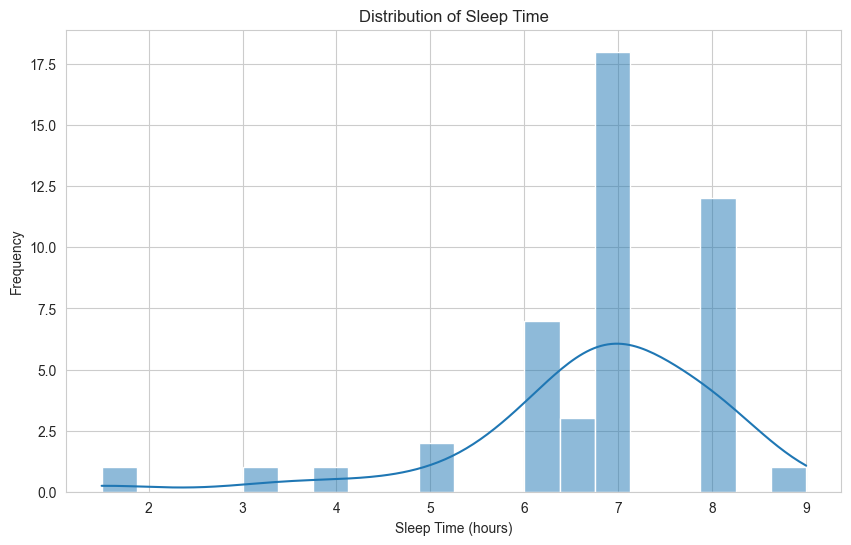

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(data['sleep time'], bins=20, kde=True)
plt.title('Distribution of Sleep Time')
plt.xlabel('Sleep Time (hours)')
plt.ylabel('Frequency')
plt.show()

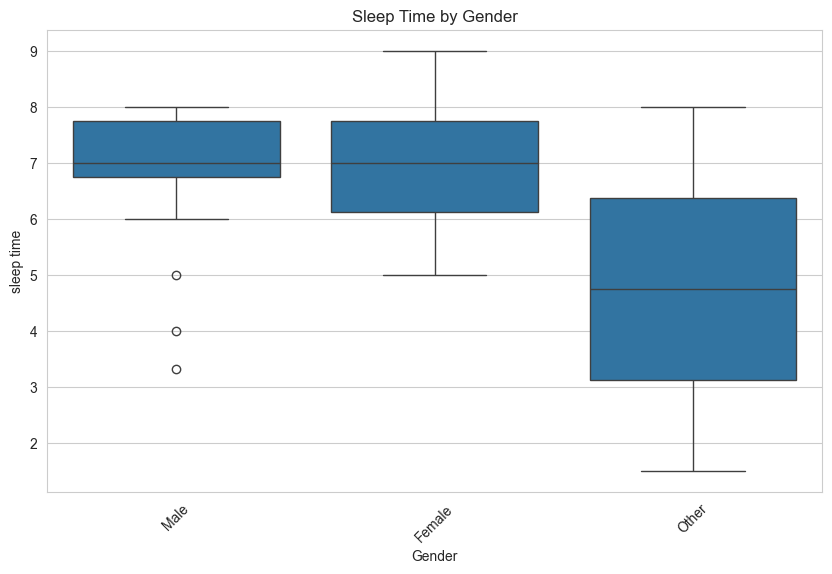

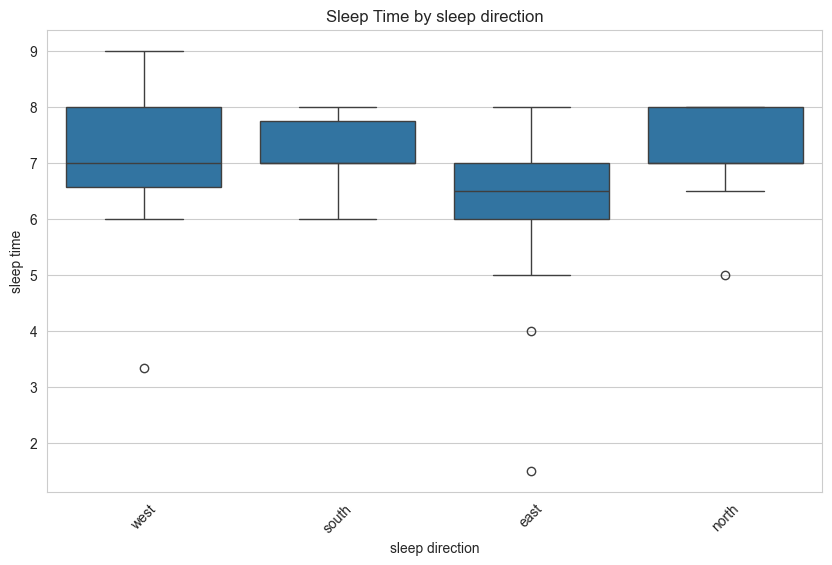

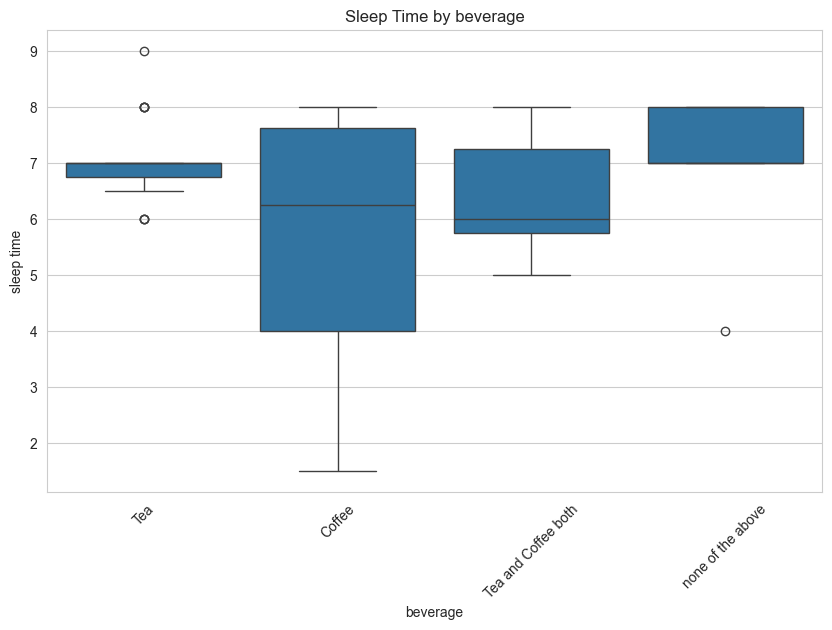

In [10]:
categorical_cols = ['Gender', 'sleep direction', 'beverage']

for col in categorical_cols:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=col, y='sleep time', data=data)
    plt.title(f'Sleep Time by {col}')
    plt.xticks(rotation=45)
    plt.show()


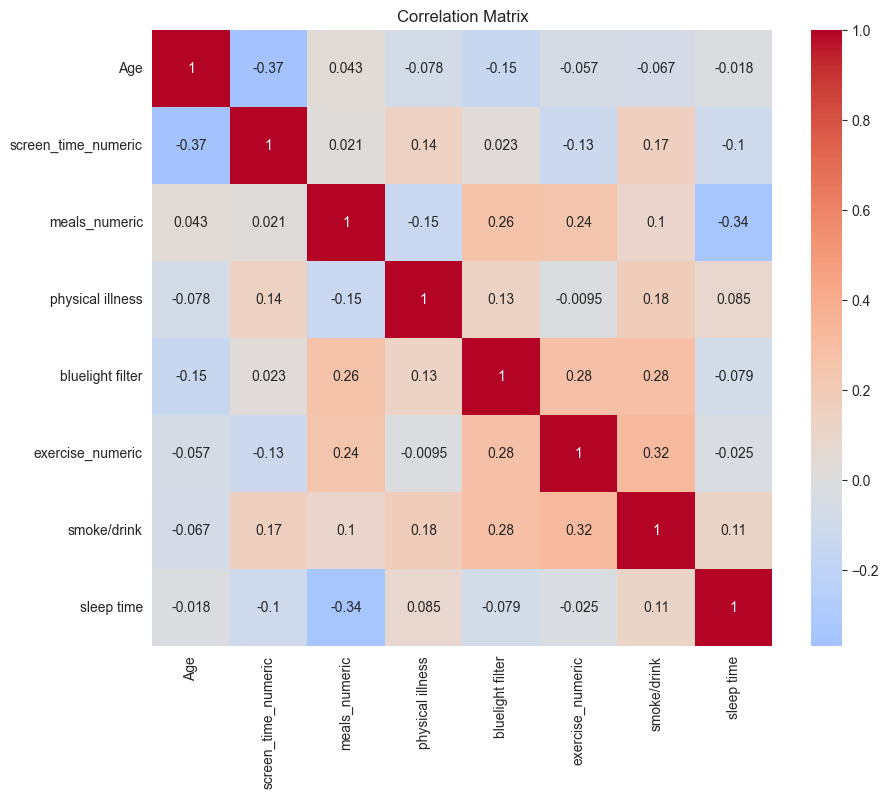

In [11]:
numerical_cols = ['Age', 'screen_time_numeric', 'meals_numeric', 'physical illness', 
                  'bluelight filter', 'exercise_numeric', 'smoke/drink']

corr_matrix = data[numerical_cols + ['sleep time']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()


In [12]:
# Feature Engineering

# Create interaction features
data['screen_exercise_interaction'] = data['screen_time_numeric'] * data['exercise_numeric']
data['meals_screen_interaction'] = data['meals_numeric'] * data['screen_time_numeric']

# Create age groups
bins = [18, 25, 35, 50, 100]
labels = ['18-25', '26-35', '36-50', '50+']
data['age_group'] = pd.cut(data['Age'], bins=bins, labels=labels)


In [13]:
# Prepare data for modeling

# Define features and target
X = data[['Age', 'Gender', 'meals_numeric', 'physical illness', 'screen_time_numeric',
           'bluelight filter', 'sleep direction', 'exercise_numeric', 'smoke/drink',
           'beverage', 'screen_exercise_interaction', 'meals_screen_interaction']]
y = data['sleep time']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [14]:
categorical_features = ['Gender', 'sleep direction', 'beverage']
numerical_features = ['Age', 'meals_numeric', 'physical illness', 'screen_time_numeric',
                     'bluelight filter', 'exercise_numeric', 'smoke/drink',
                     'screen_exercise_interaction', 'meals_screen_interaction']

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [15]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

model.fit(X_train, y_train)

# %%
# Model Evaluation

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['Age', 'meals_numeric',
                                                   'physical illness',
                                                   'screen_time_numeric',
                                                   'bluelight filter',
                                                   'exercise_numeric',
                                                   'smoke/drink',
                                                   'screen_exercise_interaction',
                                                   'meals_screen_interaction']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender', 'sleep direction',
                                                   'beverage'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [16]:
y_pred = model.predict(X_test)



In [17]:

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Model Performance:")
print(f"Mean Absolute Error: {mae:.2f} hours")
print(f"R-squared: {r2:.2f}")

Model Performance:
Mean Absolute Error: 1.24 hours
R-squared: -0.86


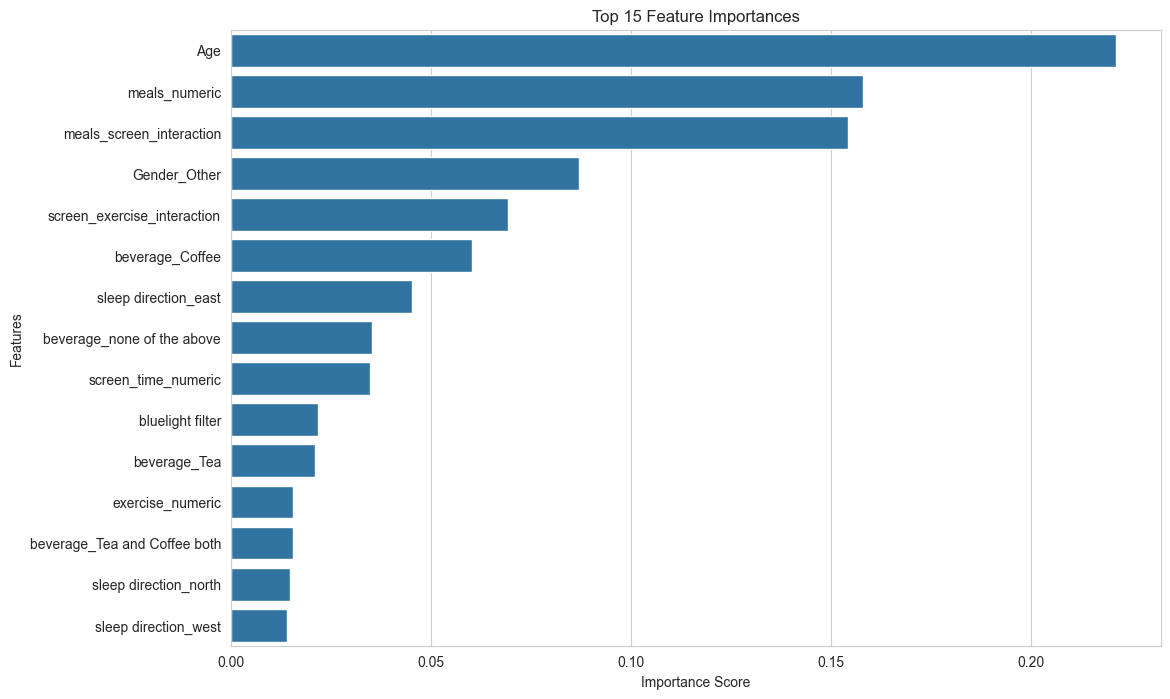

In [19]:
# Get feature names after preprocessing
# First get the one-hot encoded feature names for all categorical features at once
preprocessor = model.named_steps['preprocessor']
onehot_encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']

# Get all categorical feature names at once
categorical_features_all = onehot_encoder.get_feature_names_out(categorical_features)

# Combine with numerical features
feature_names = numerical_features + list(categorical_features_all)

# Get feature importances
importances = model.named_steps['regressor'].feature_importances_

# Sort features by importance
sorted_idx = importances.argsort()[::-1]

# Plot top 15 features
plt.figure(figsize=(12, 8))
sns.barplot(x=importances[sorted_idx][:15], y=np.array(feature_names)[sorted_idx][:15])
plt.title('Top 15 Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

In [20]:
# Advanced Analysis: Clustering Sleep Patterns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Select features for clustering
cluster_features = data[['screen_time_numeric', 'exercise_numeric', 'meals_numeric', 'sleep time']]

# Scale the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(cluster_features)

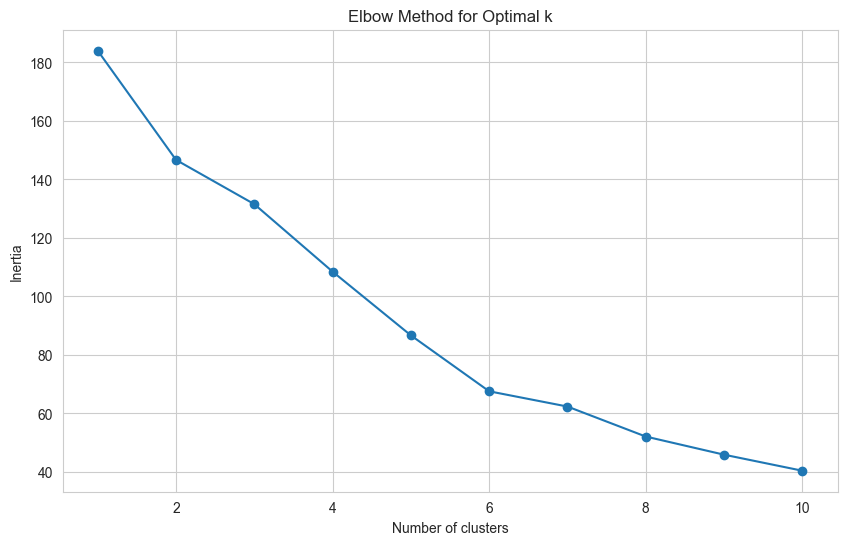

In [21]:
# Determine optimal number of clusters using elbow method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

# Based on the elbow, let's choose 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(scaled_features)
data['sleep_cluster'] = clusters


In [22]:
# Analyze clusters
cluster_analysis = data.groupby('sleep_cluster')[['screen_time_numeric', 'exercise_numeric', 
                                                 'meals_numeric', 'sleep time']].mean()
print("\nCluster Analysis:")
print(cluster_analysis)


Cluster Analysis:
               screen_time_numeric  exercise_numeric  meals_numeric  \
sleep_cluster                                                         
0                         5.769231          1.153846       2.384615   
1                         2.770833          1.291667       2.750000   
2                         4.222222          0.111111       3.000000   

               sleep time  
sleep_cluster              
0                7.230769  
1                6.243542  
2                7.444444  


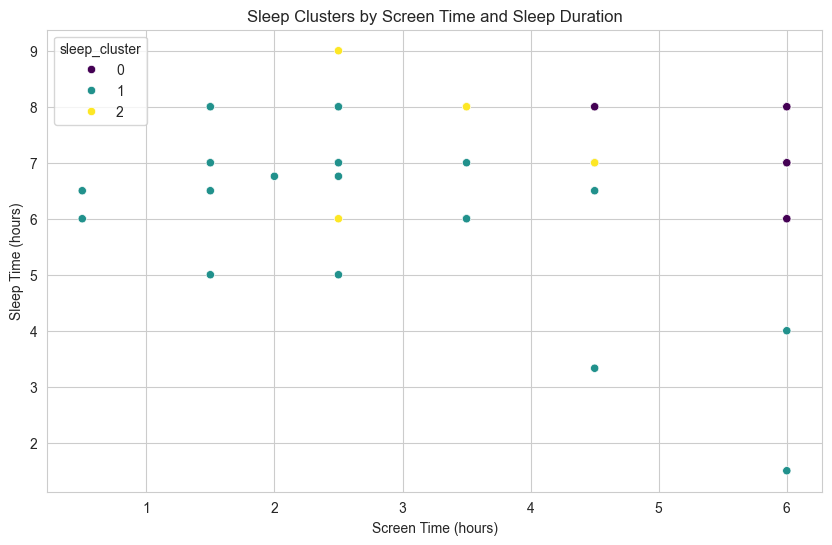

In [23]:
# Visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='screen_time_numeric', y='sleep time', hue='sleep_cluster', data=data, palette='viridis')
plt.title('Sleep Clusters by Screen Time and Sleep Duration')
plt.xlabel('Screen Time (hours)')
plt.ylabel('Sleep Time (hours)')
plt.show()

In [24]:
# Recommendations Engine
def generate_recommendations(row):
    recommendations = []
    
    if row['sleep time'] < 6:
        recommendations.append("Your sleep duration is below the recommended 7-9 hours for adults.")
    
    if row['screen_time_numeric'] > 3:
        recommendations.append(f"Reduce screen time before bed (currently {row['screen_time_numeric']} hours). Consider using blue light filters consistently.")
    
    if row['exercise_numeric'] < 1:
        recommendations.append("Increasing physical activity may improve sleep quality.")
    
    if row['meals_numeric'] > 3:
        recommendations.append("Having fewer, more balanced meals might help with sleep quality.")
    
    if row['smoke/drink'] == 1:
        recommendations.append("Reducing alcohol/tobacco consumption may improve sleep quality.")
    
    if not recommendations:
        return "Your current habits seem generally good for sleep. Maintain your routine!"
    
    return "Recommendations:\n- " + "\n- ".join(recommendations)

In [25]:
# Example recommendation
sample_person = data.iloc[0]
print("\nExample Sleep Recommendations:")
print(generate_recommendations(sample_person))


Example Sleep Recommendations:
Your current habits seem generally good for sleep. Maintain your routine!


In [26]:
import joblib

# Save the trained model
joblib.dump(model, 'sleep_model.pkl')

# Save the column transformer (for preprocessing new data)
joblib.dump(preprocessor, 'preprocessor.pkl')

print("Model and preprocessor saved successfully!")

Model and preprocessor saved successfully!
